In [51]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [146]:
import pandas as pd

data = pd.read_csv("../data/heart_failure_clinical_records.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


In [147]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,60.288736,0.474400,586.760600,0.439400,37.734600,0.364800,265075.404370,1.369106,136.808200,0.645600,0.311800,130.678800,0.313600
std,11.697243,0.499394,976.733979,0.496364,11.514855,0.481422,97999.758622,1.009750,4.464236,0.478379,0.463275,77.325928,0.464002
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.500000,113.000000,0.000000,0.000000,4.000000,0.000000
25%,50.000000,0.000000,121.000000,0.000000,30.000000,0.000000,215000.000000,0.900000,134.000000,0.000000,0.000000,74.000000,0.000000
50%,60.000000,0.000000,248.000000,0.000000,38.000000,0.000000,263358.030000,1.100000,137.000000,1.000000,0.000000,113.000000,0.000000
75%,68.000000,1.000000,582.000000,1.000000,45.000000,1.000000,310000.000000,1.400000,140.000000,1.000000,1.000000,201.000000,1.000000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.400000,148.000000,1.000000,1.000000,285.000000,1.000000


In [148]:
#checking for any missing data.

data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [149]:
for feature in data.columns:
    print(feature, ':', len(data[feature].unique()))

age : 48
anaemia : 2
creatinine_phosphokinase : 290
diabetes : 2
ejection_fraction : 17
high_blood_pressure : 2
platelets : 203
serum_creatinine : 43
serum_sodium : 27
sex : 2
smoking : 2
time : 155
DEATH_EVENT : 2


In [150]:
#classifying features as continuous or discrete.

discrete_features, continuous_features = [], []
for feature in data.columns:
    if feature == 'DEATH_EVENT':
        label = ['DEATH_EVENT']
    elif len(data[feature].unique()) >= 10:
        continuous_features.append(feature)
    else:
        discrete_features.append(feature)

print('Discrete: ', discrete_features, '\n','Continuous: ', continuous_features)

Discrete:  ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking'] 
 Continuous:  ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


In [151]:
data[continuous_features[0]]

0       55.0
1       65.0
2       45.0
3       60.0
4       95.0
        ... 
4995    45.0
4996    60.0
4997    95.0
4998    65.0
4999    40.0
Name: age, Length: 5000, dtype: float64

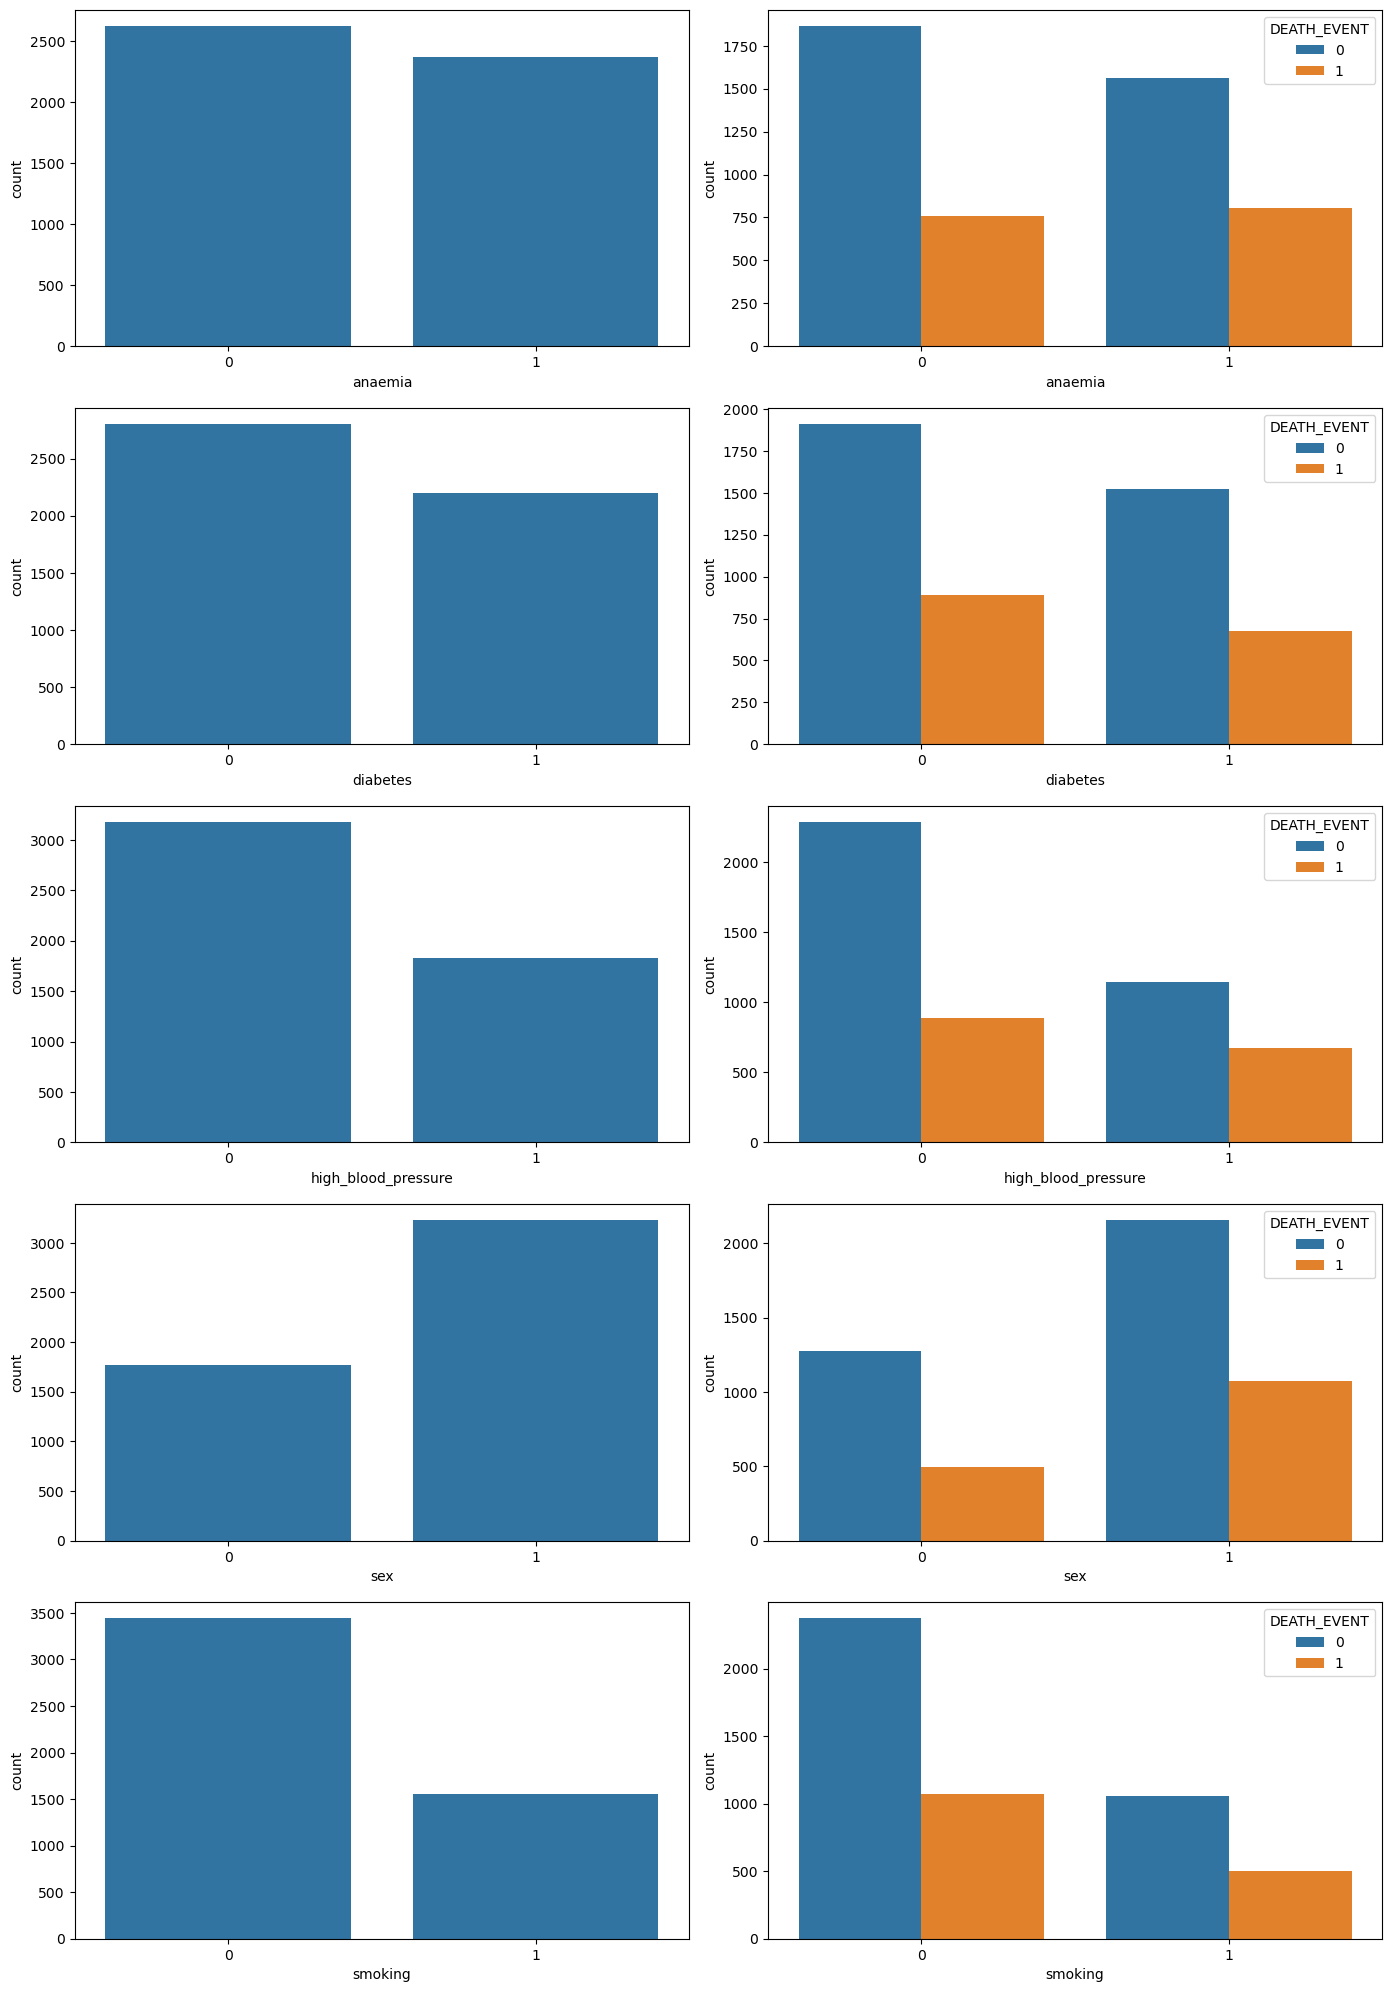

In [152]:
#plots of discrete features

fig, ax = plt.subplots(len(discrete_features), 2, figsize=(14, 20))

for i in range(len(discrete_features)):
    sb.countplot(ax=ax[i, 0], x=discrete_features[i], data=data)
    sb.countplot(ax=ax[i, 1], x=discrete_features[i],
                 hue='DEATH_EVENT', data=data)
fig.tight_layout(pad=1)
plt.show()

<Axes: xlabel='DEATH_EVENT', ylabel='count'>

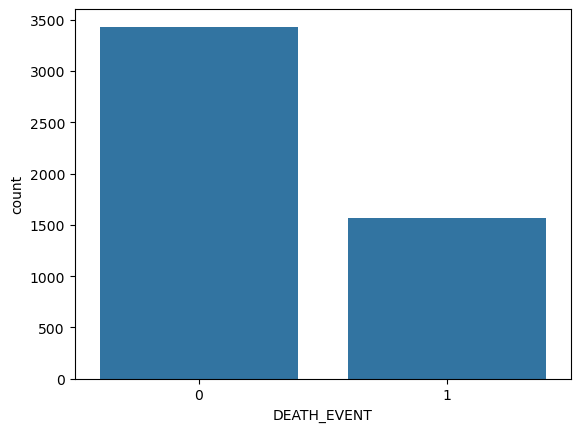

In [153]:
sb.countplot(x='DEATH_EVENT', data=data)


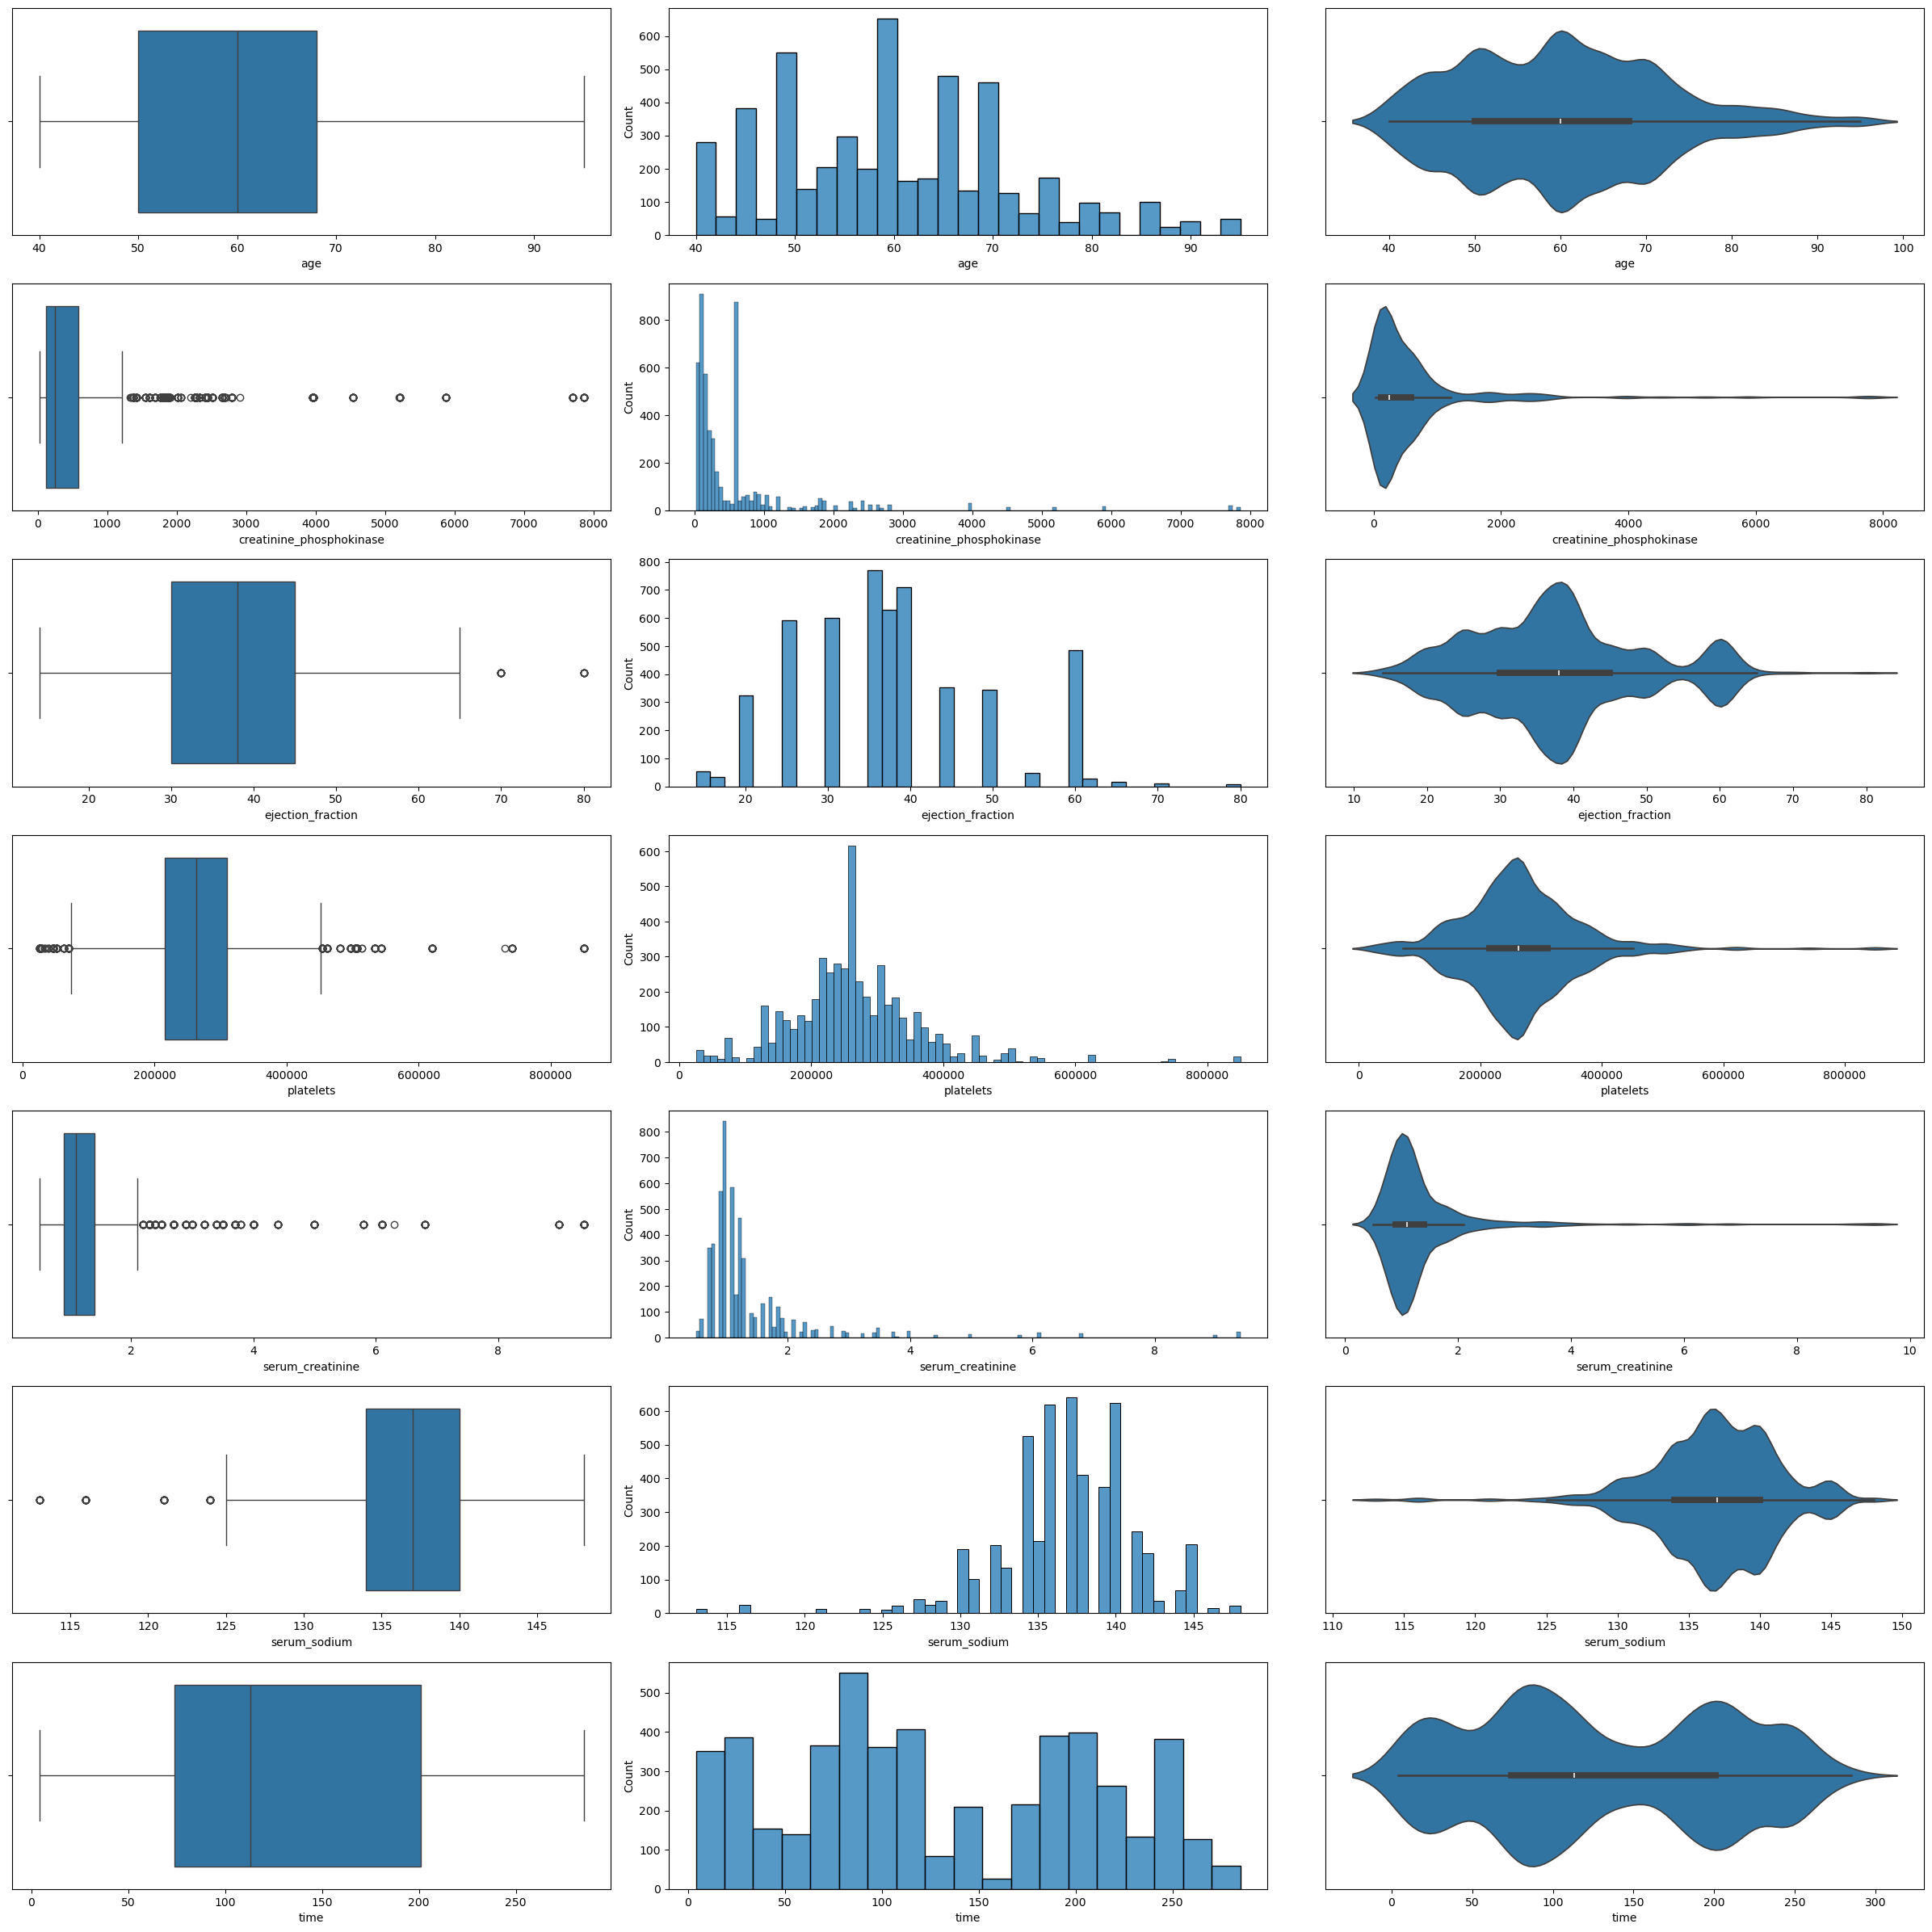

In [154]:
import matplotlib.pyplot as plt
import seaborn as sb

fig, axes = plt.subplots(len(continuous_features), 3, figsize=(24, 24))

for i in range(len(continuous_features)):
    
    sb.boxplot(
        ax=axes[i, 0],
        x=continuous_features[i],
        data=data,
        orient="h"
    )

    sb.histplot(
        ax=axes[i, 1],
        x=continuous_features[i],
        data=data
    )

    sb.violinplot(
        ax=axes[i, 2],
        x=continuous_features[i],
        data=data,
        orient="h"
    )

fig.tight_layout(pad=1)
plt.show()

In [61]:
import numpy as np
from collections import Counter

def detect_outliers(df, features):
    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.extend(outliers)

    outlier_counts = Counter(outlier_indices)

    # rows that appear as outliers in more than one feature
    multiple_outliers = [i for i, v in outlier_counts.items() if v > 1]

    return multiple_outliers

In [62]:
data.loc[detect_outliers(data,["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"])]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
70,60.0,0,2656,1,38,0,329000.0,3.0,142,0,0,30,1
140,60.0,0,1896,0,38,0,224000.0,2.5,134,1,0,172,1
184,51.0,0,1380,0,25,1,27100.0,0.9,130,1,0,38,1
217,50.0,0,1548,0,35,1,388000.0,9.4,133,1,1,10,1
233,60.0,0,2656,0,40,0,286000.0,2.3,131,0,0,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4685,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
4754,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
4942,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
4994,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1


In [63]:
data = data.drop(detect_outliers(data,["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"]),axis = 0).reset_index(drop=True)

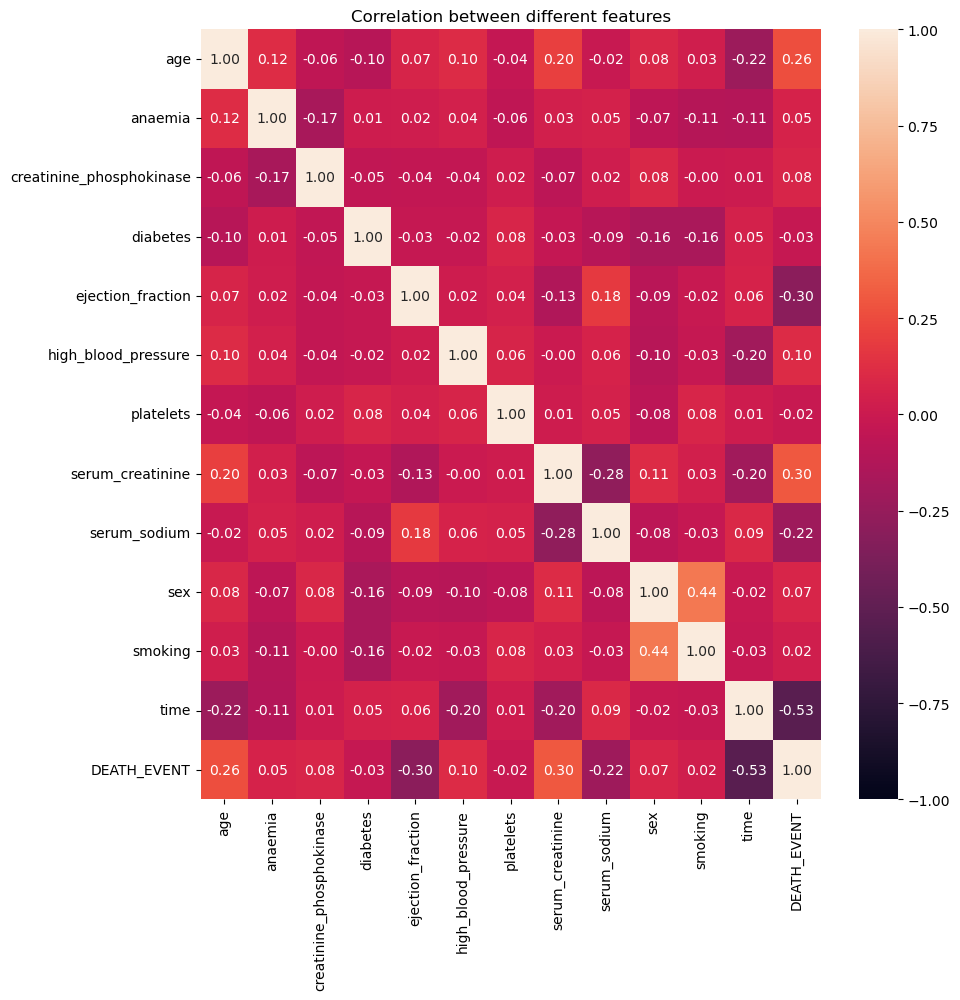

In [74]:
#plotting correlation plot.

plt.figure(figsize=(10, 10))
sb.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation between different features")
plt.show()

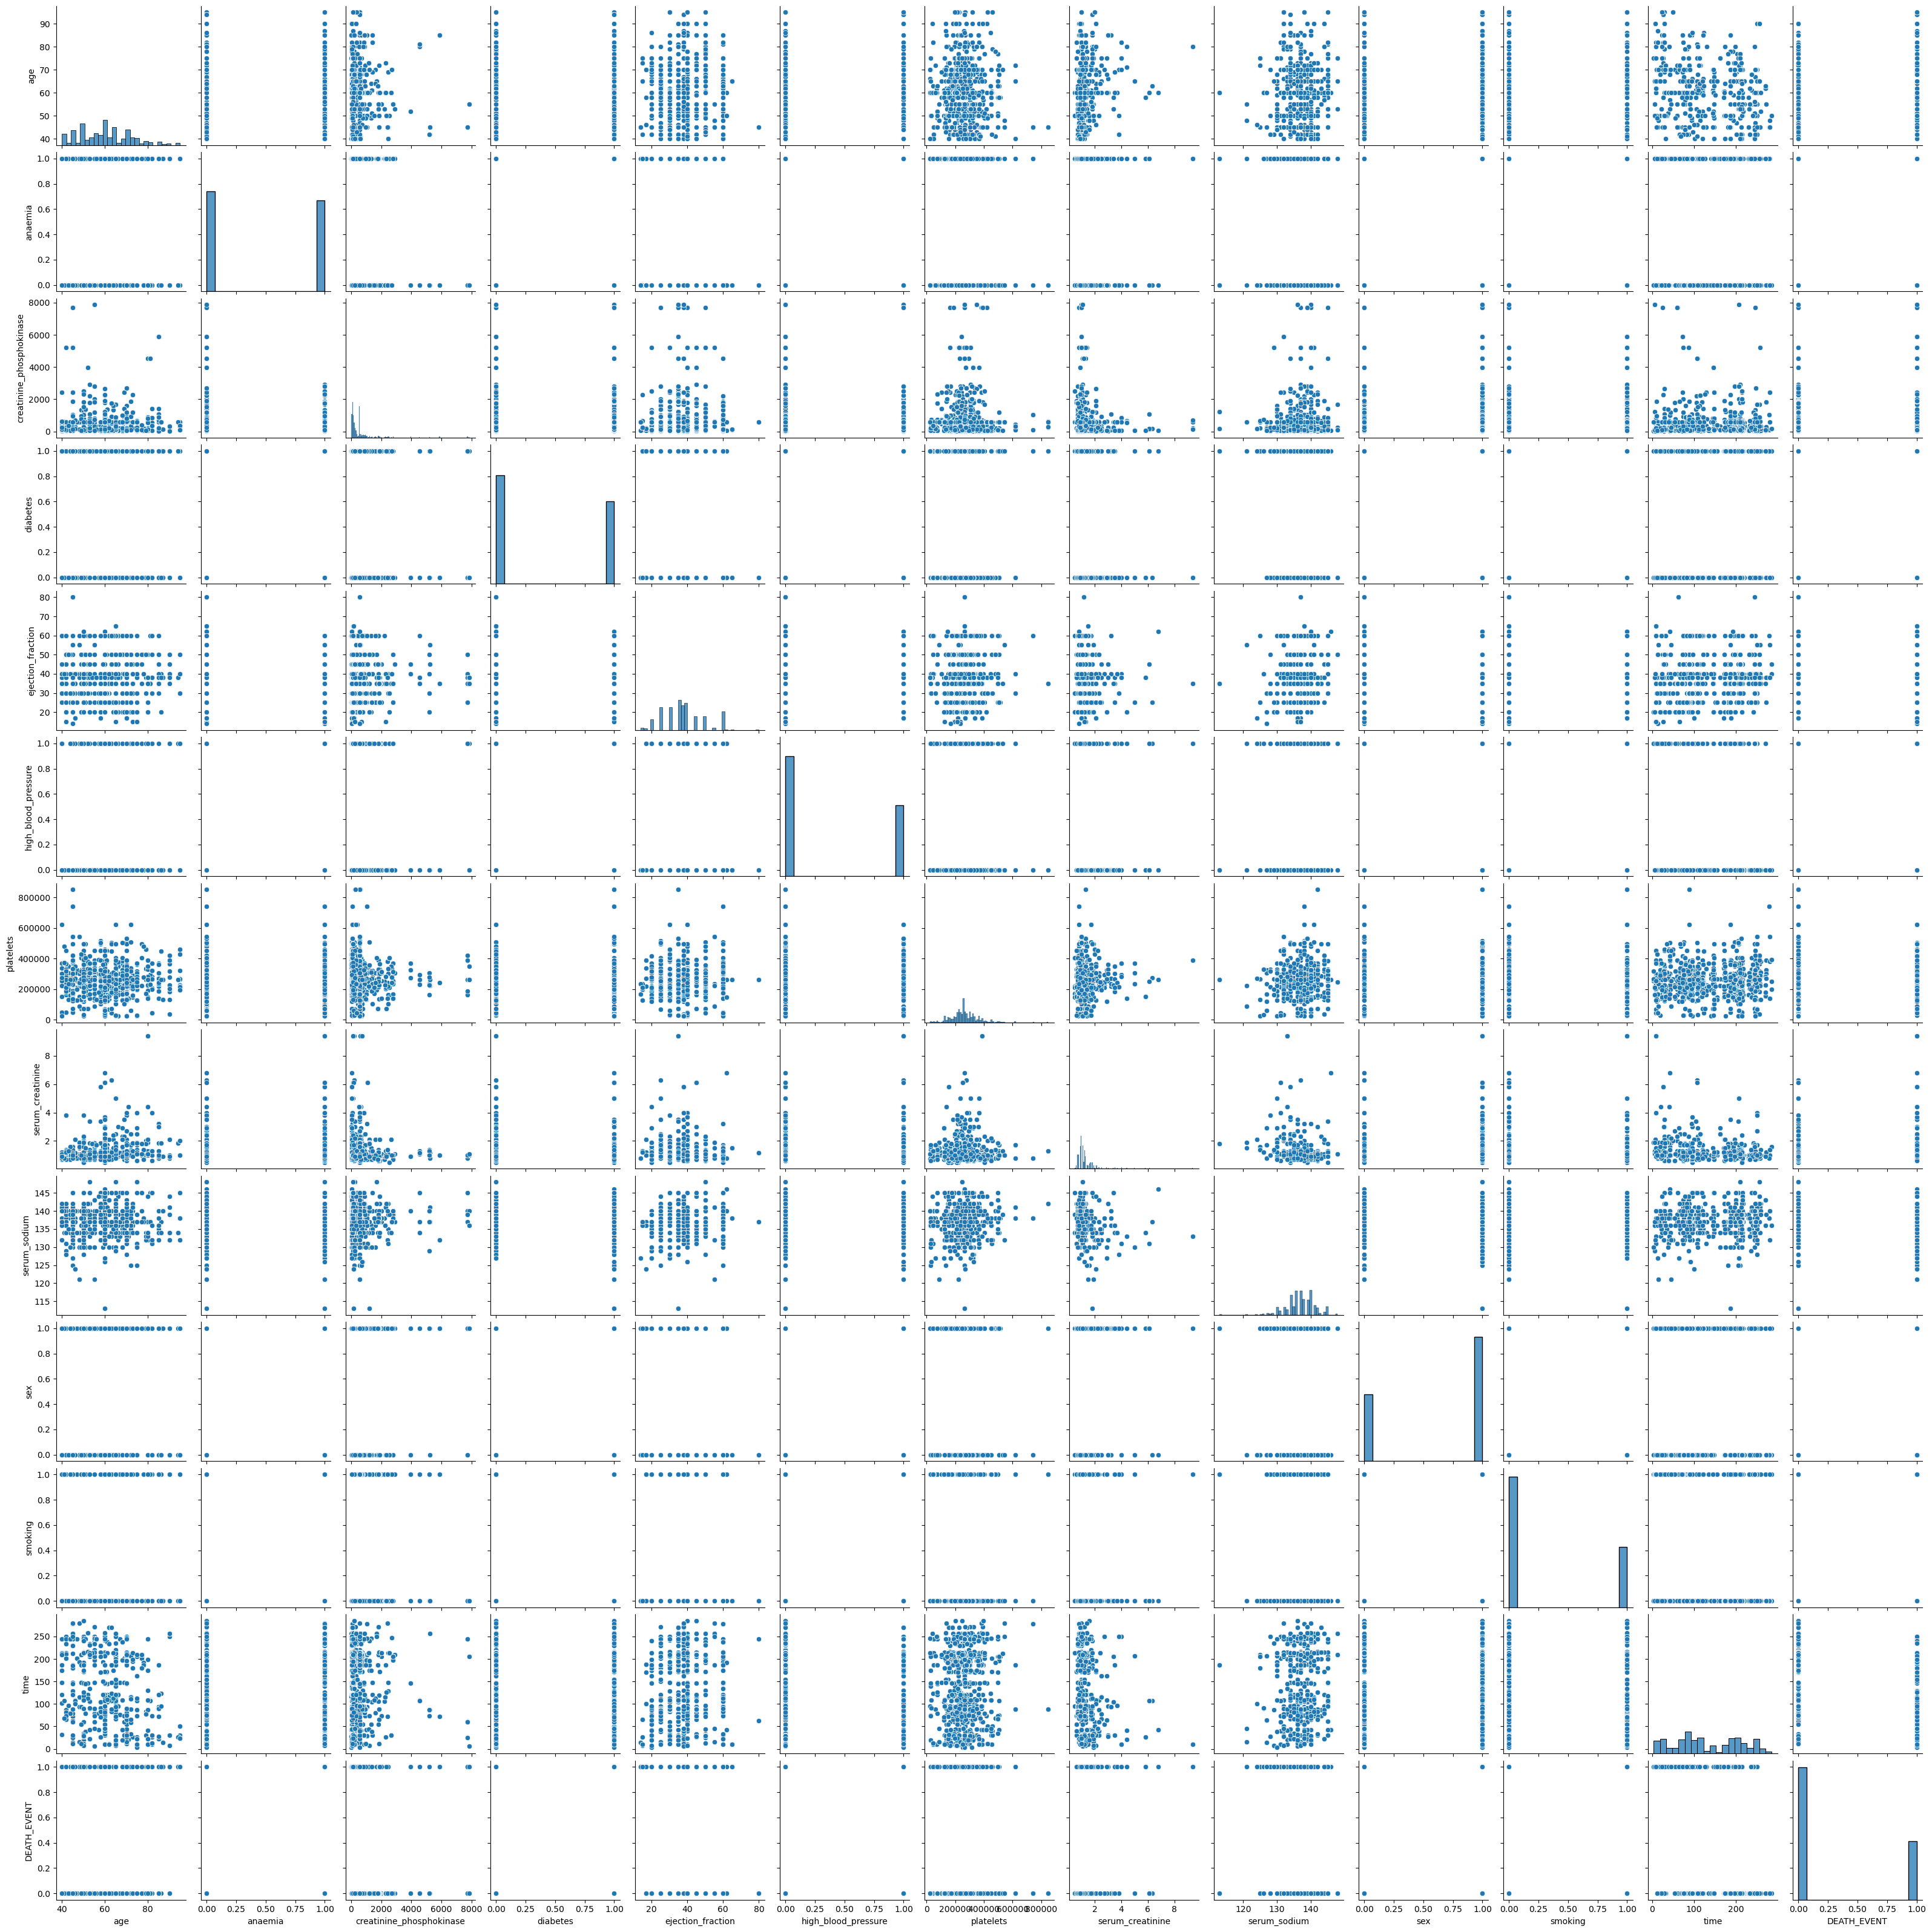

In [65]:
#pair plot

sb.pairplot(data=data)

Most variables show weak linear correlation with mortality; however, nonlinear models and regularization revealed several features still contribute meaningfully to prediction.

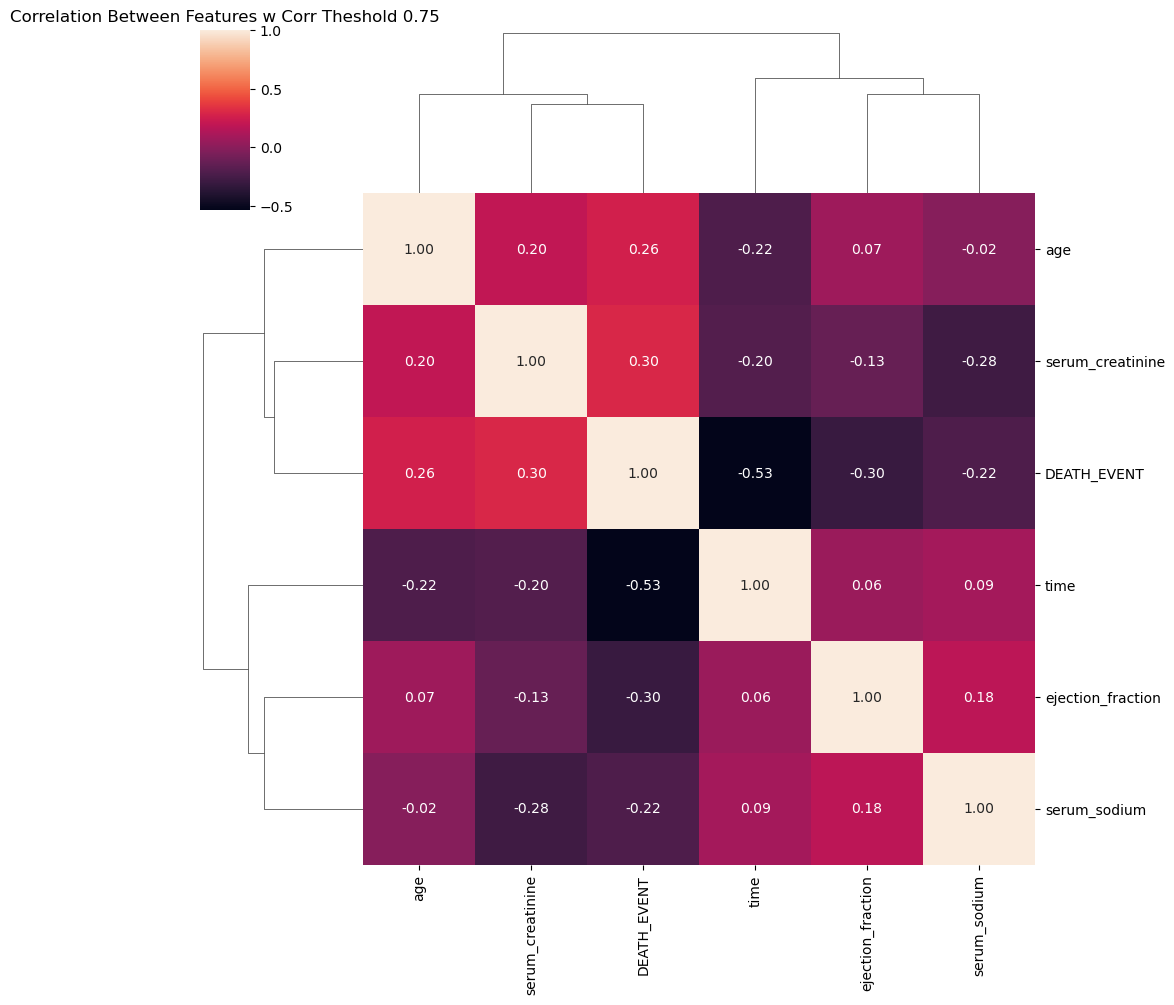

In [66]:
#filtering out weakly correlated features

threshold = 0.2
filtre = np.abs(data.corr()["DEATH_EVENT"]) > threshold
corr_features = data.corr().columns[filtre].tolist()
sb.clustermap(data[corr_features].corr(), annot=True, fmt=".2f")
plt.title("Correlation Between Features w Corr Theshold 0.75")
plt.show()

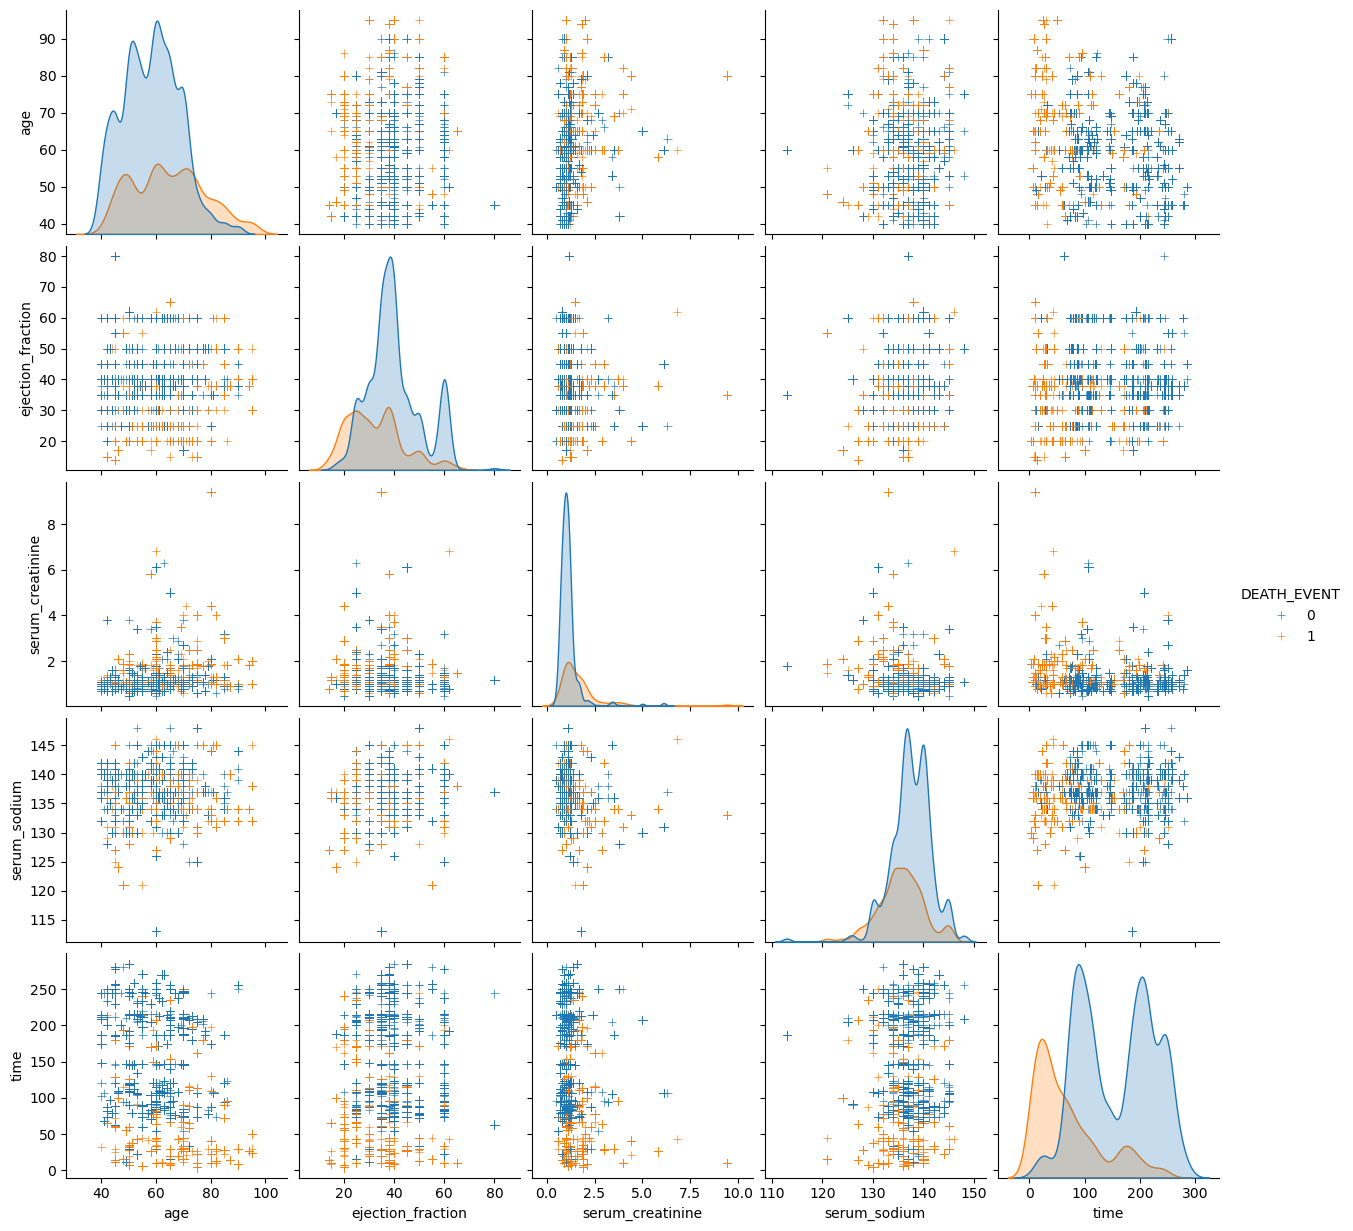

In [67]:
#pair plot

sb.pairplot(data[corr_features], diag_kind="kde",
             markers="+", hue="DEATH_EVENT")
plt.show()

First Using Classification Models namely the correlation plot and the trained decision tree we can try to predict which factors have the most influence on the Death Rate. The data set in randomly split into test data (25% of the whole data) and train data. The train data can be used to create a classification model and tested with the test data we have. 

### Multi-variate Decision Tree based on numerical variables

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 90.95905468535311 %

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 87.79884583676835 %



<Axes: >

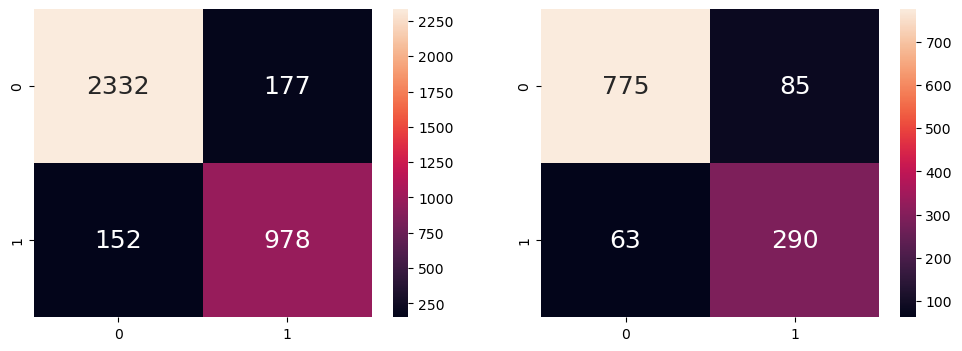

In [68]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Extract Response and Predictors
predictors = ["creatinine_phosphokinase", "ejection_fraction", "serum_creatinine", "platelets", "serum_sodium", "time", "age"]

y = pd.DataFrame(data['DEATH_EVENT'])
X = pd.DataFrame(data[predictors]) 

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train)*100, "%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test)*100, "%")
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

The model achieved a training accuracy of approximately 91% and a test accuracy of 88%, indicating strong predictive performance with minimal overfitting. The close alignment between training and testing results suggests good generalization to unseen data. The confusion matrices further show balanced classification performance across both classes, demonstrating the model’s effectiveness in identifying mortality outcomes.

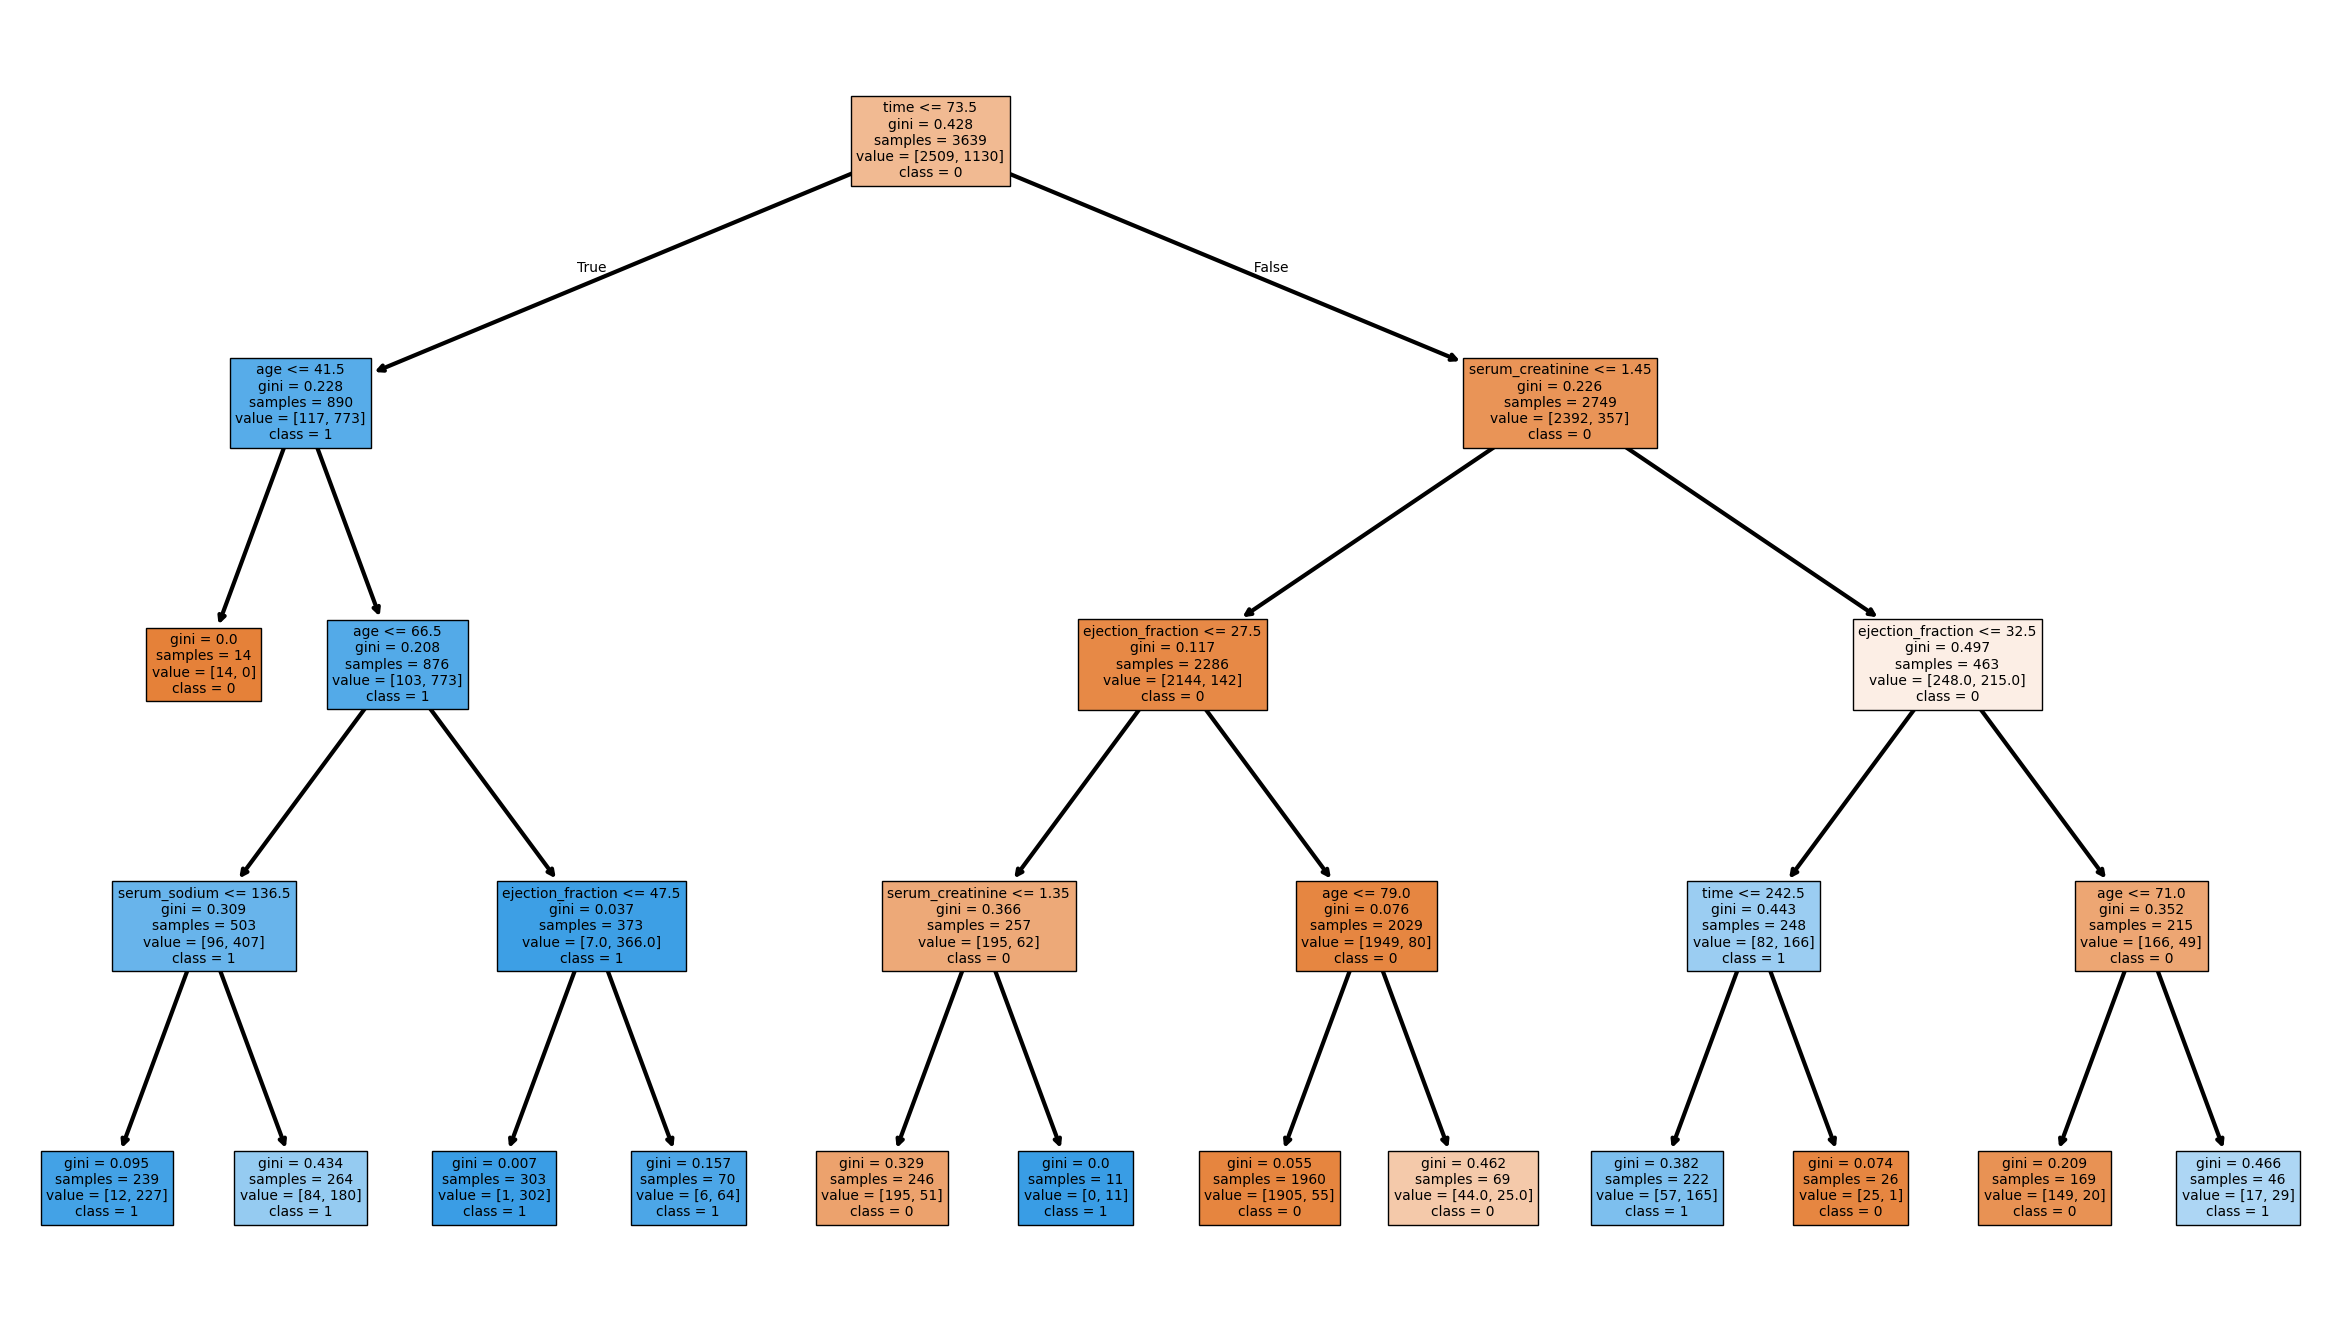

In [69]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(30, 17))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

### Decision tree based on categorical variables 

In [70]:
CatData = pd.DataFrame(data[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']])
CatData.info()
for col in CatData:
    CatData[col] = CatData[col].astype('category')#Modifying the category
CatData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4852 entries, 0 to 4851
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   anaemia              4852 non-null   int64
 1   diabetes             4852 non-null   int64
 2   high_blood_pressure  4852 non-null   int64
 3   sex                  4852 non-null   int64
 4   smoking              4852 non-null   int64
 5   DEATH_EVENT          4852 non-null   int64
dtypes: int64(6)
memory usage: 227.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4852 entries, 0 to 4851
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   anaemia              4852 non-null   category
 1   diabetes             4852 non-null   category
 2   high_blood_pressure  4852 non-null   category
 3   sex                  4852 non-null   category
 4   smoking              4852 non-null   category
 5   DE

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 70.45891728496841 %

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 69.16735366859027 %



<Axes: >

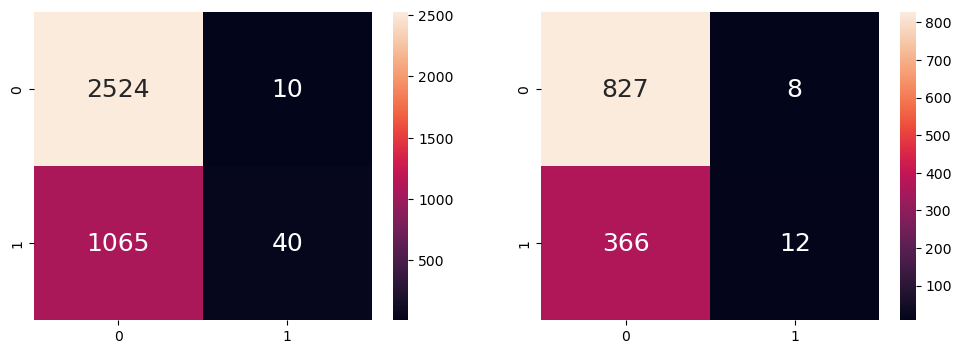

In [71]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Extract Response and Predictors
y = pd.DataFrame(data['DEATH_EVENT'])
X = pd.DataFrame(CatData[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']]) 

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 3)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train)*100, "%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test)*100, "%")
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

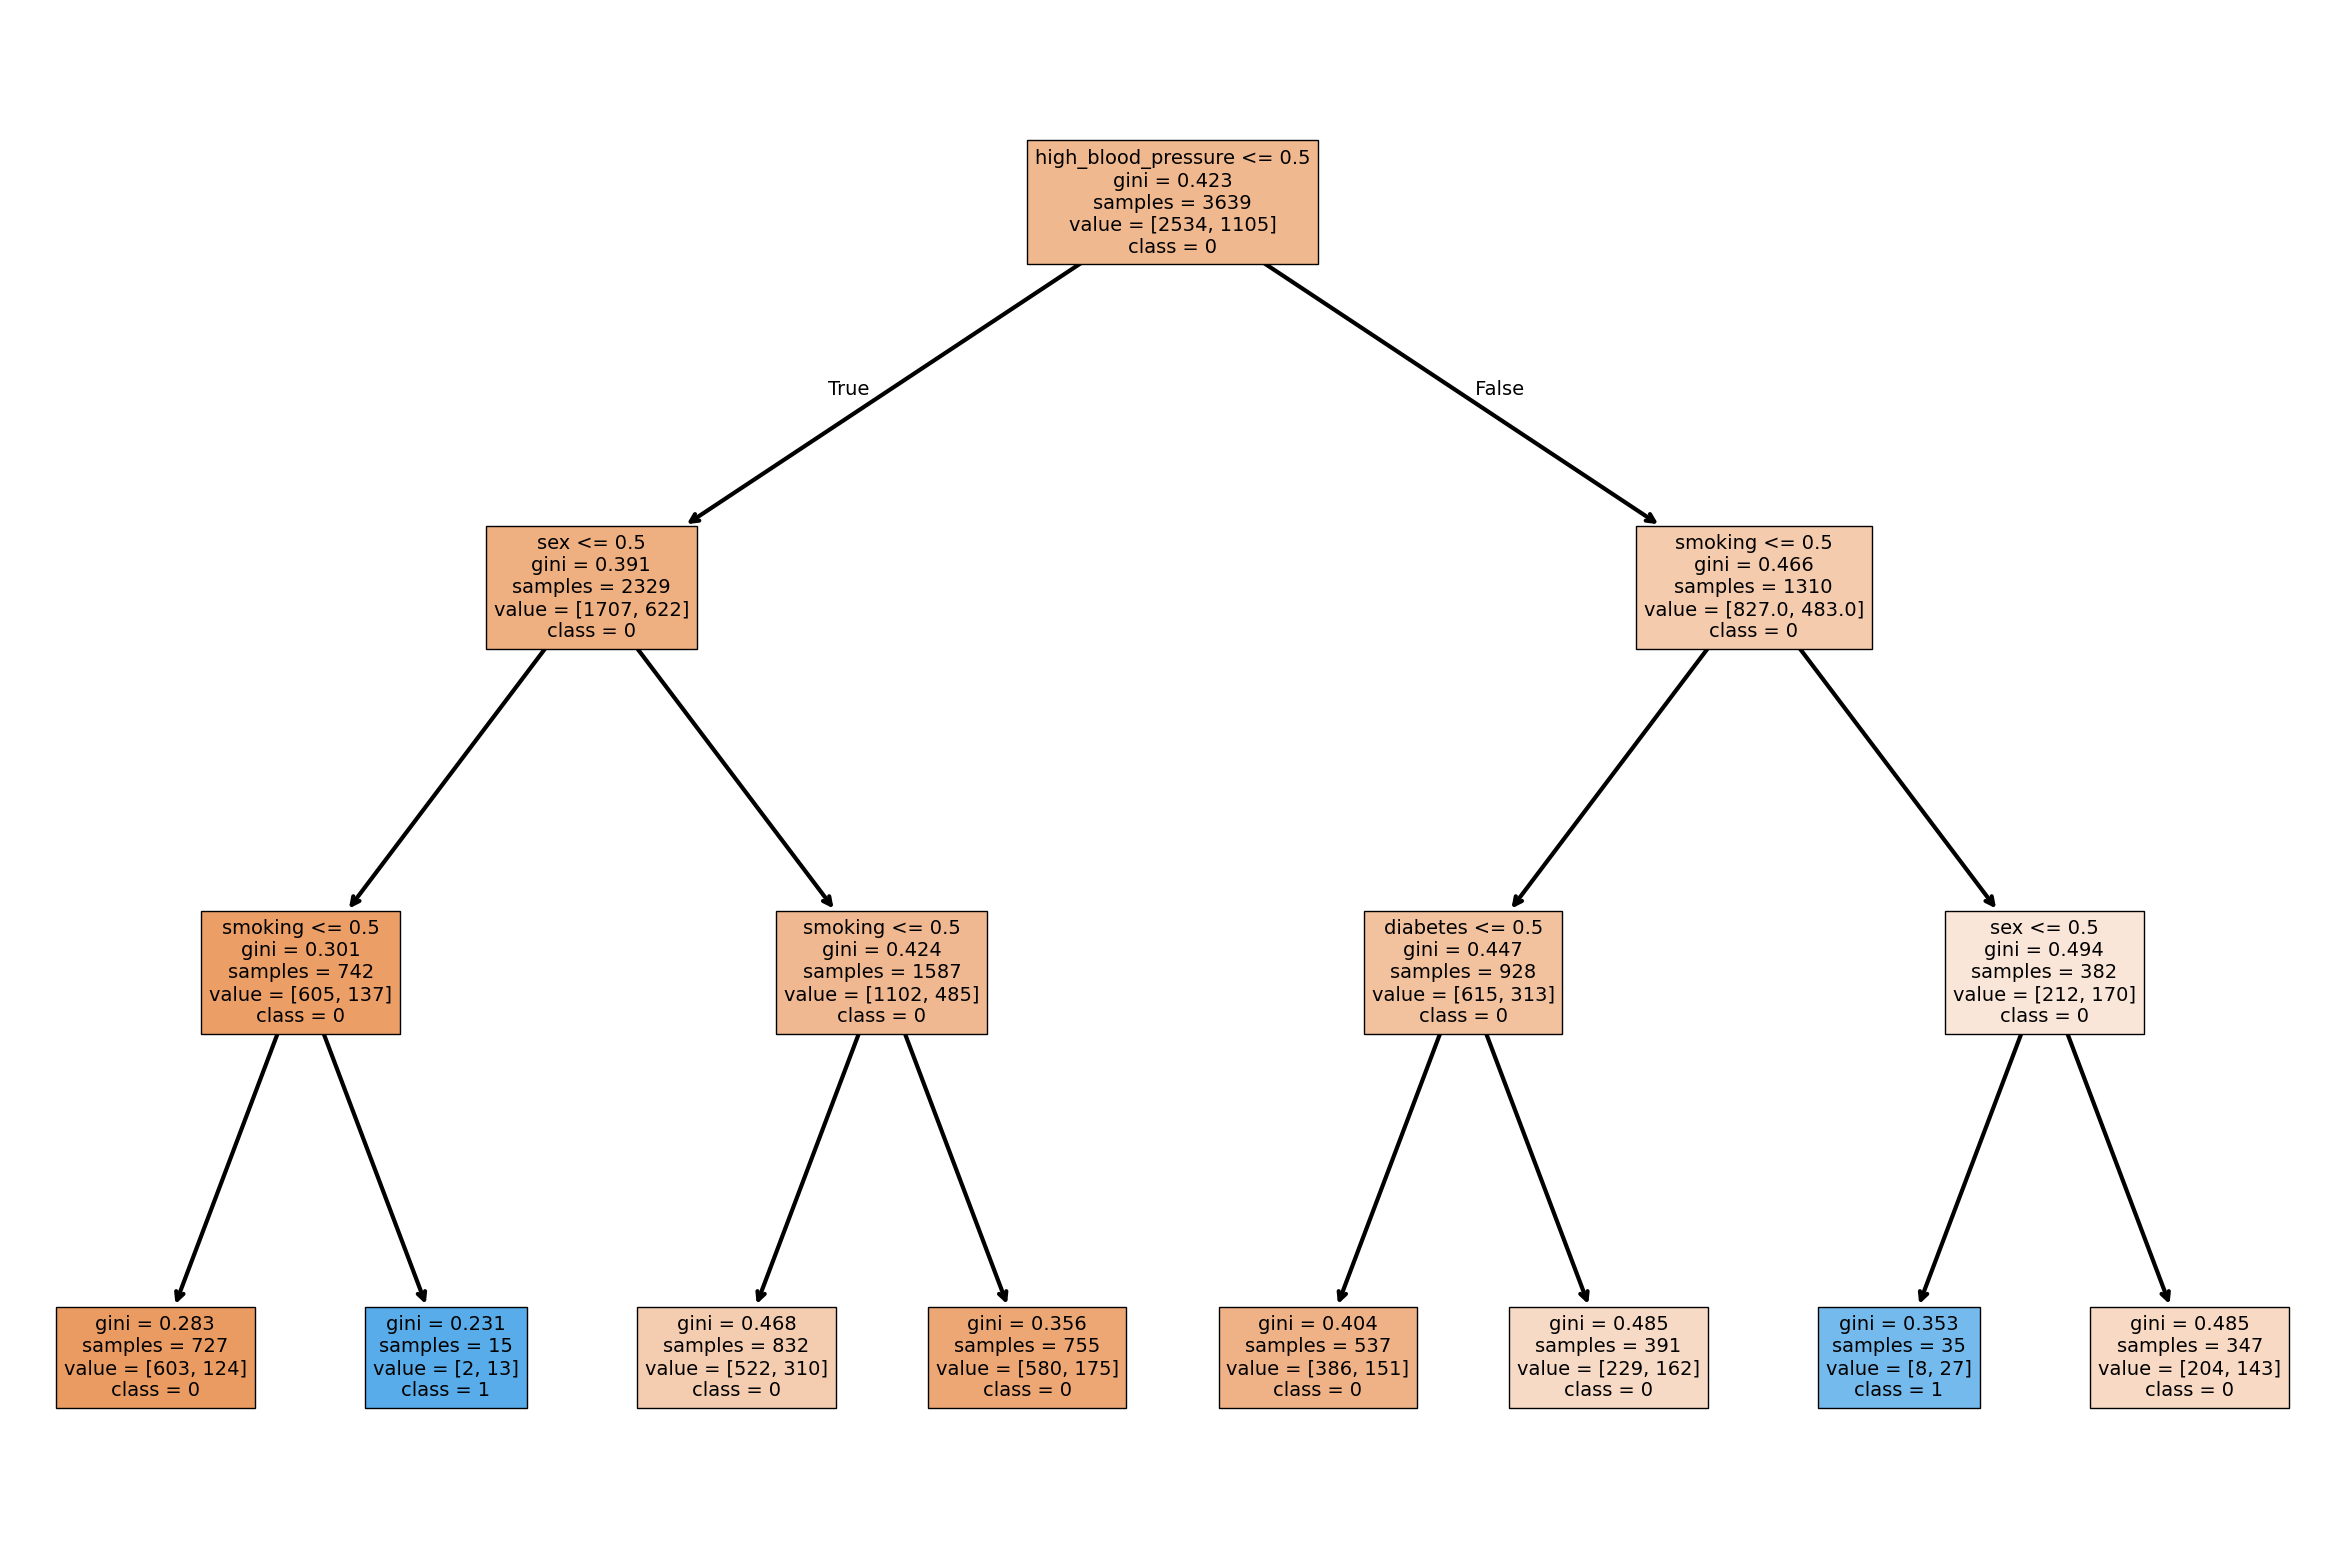

In [75]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(30, 20))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

In [81]:
# X, y
X = data.drop(columns=["DEATH_EVENT"])
y = data["DEATH_EVENT"]

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# L1 logistic regression 
selector = SelectFromModel(
    LogisticRegression(penalty="l1", solver="liblinear", C=1.0, random_state=0, max_iter=5000)
)

selector.fit(X_scaled, y)

considered_features = X.columns[selector.get_support()]
print("Considered features:", list(considered_features))

Considered features: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']


In [83]:
#printing out weakly correlated features; moderate L1 regularization was applied
#removing minimally contributing variables while preserving clinically relevant predictors.

X = data.drop(columns=["DEATH_EVENT"])
y = data["DEATH_EVENT"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectFromModel(
    LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=0.1,   # stronger regularization
        max_iter=5000
    )
)

selector.fit(X_scaled, y)

features = X.columns

conisdered_features = features[selector.get_support()]
removed_features = features[~selector.get_support()]

print("Considered features:", list(considered_features))
print("Removed features:", list(removed_features))

Considered features: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']
Removed features: ['platelets', 'sex', 'smoking']


### Observations
The L1-regularized model retained most clinical features and removed platelet count, sex, and smoking, suggesting these variables added limited predictive value.

### Model Building without Sampling using logistical regression and random forest classifiers

In [84]:
X = data.drop(['DEATH_EVENT'], axis=1)
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(3881, 12) (971, 12)


Accuracy: 85.16992790937178 %
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       674
           1       0.79      0.70      0.74       297

    accuracy                           0.85       971
   macro avg       0.83      0.81      0.82       971
weighted avg       0.85      0.85      0.85       971



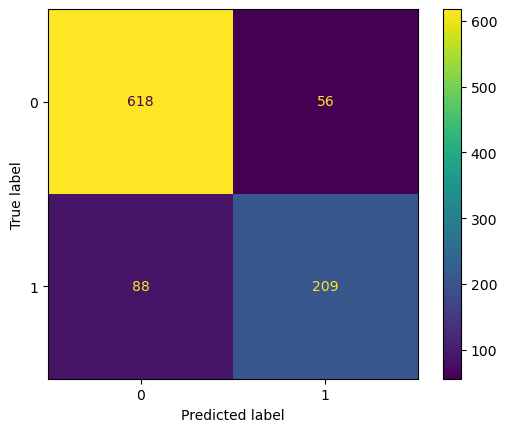

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Accuracy & report
print("Accuracy:", accuracy_score(y_test, y_pred) * 100, "%")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Accuracy of Random Forest: 98.97013388259526 %
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       674
           1       1.00      0.97      0.98       297

    accuracy                           0.99       971
   macro avg       0.99      0.98      0.99       971
weighted avg       0.99      0.99      0.99       971



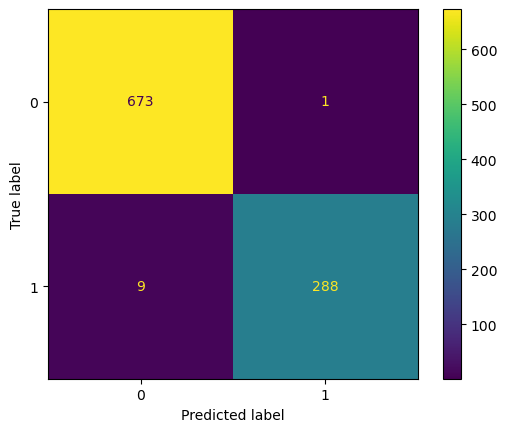

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Metrics
print("Accuracy of Random Forest:", accuracy_score(y_test, y_pred) * 100, "%")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Considering all the features, the accuracy with Logistic Regression is 85% and Random Forest is 99%

### Trying with different sets of features based on the observations.


In [128]:
X = data[['creatinine_phosphokinase',
          'ejection_fraction',
          'serum_creatinine',
          'time',
          ]]
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(3881, 4) (971, 4)


Accuracy: 80.84449021627188 %
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       667
           1       0.65      0.83      0.73       304

    accuracy                           0.81       971
   macro avg       0.78      0.81      0.79       971
weighted avg       0.83      0.81      0.81       971



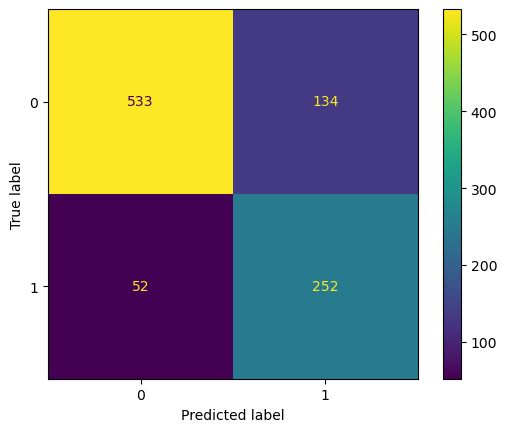

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

model = LogisticRegression(max_iter=5000, class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Accuracy of Random Forest: 98.97013388259526 %
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       667
           1       1.00      0.97      0.98       304

    accuracy                           0.99       971
   macro avg       0.99      0.98      0.99       971
weighted avg       0.99      0.99      0.99       971



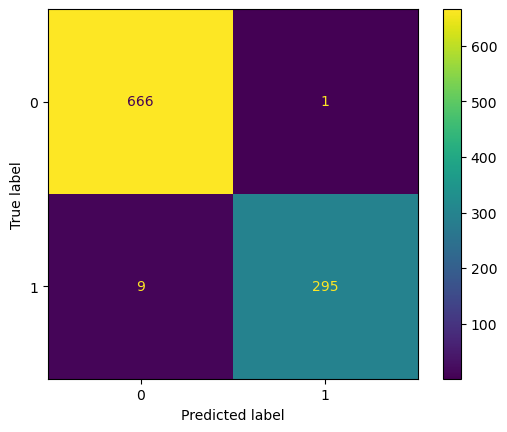

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Accuracy + report
print("Accuracy of Random Forest:", accuracy_score(y_test, y_pred) * 100, "%")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Conclusion:
L1-regularized feature selection eliminated a small number of weak predictors, with creatinine phosphokinase, ejection fraction, serum creatinine, and survival time emerging as the most influential features for mortality prediction.


The accuracies are:
* Logistic Regression --> 81%
* Random Forest -->99%

In [131]:
X = data[['ejection_fraction', 'serum_creatinine', 'time']]
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)
print(X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(3881, 3) (971, 3)


Accuracy of Logistic Regression: 83.9340885684861 %
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       667
           1       0.78      0.68      0.73       304

    accuracy                           0.84       971
   macro avg       0.82      0.80      0.81       971
weighted avg       0.84      0.84      0.84       971



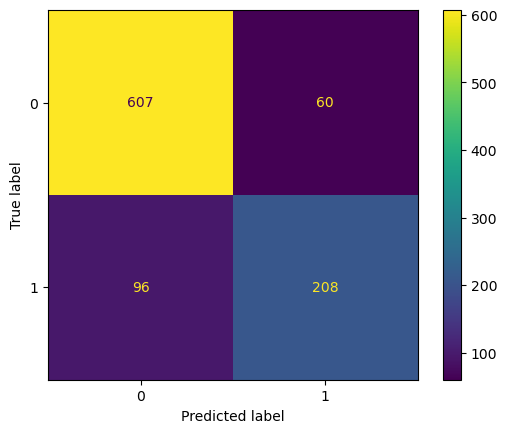

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Accuracy + report
print("Accuracy of Logistic Regression:", accuracy_score(y_test, y_pred) * 100, "%")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Accuracy of Random Forest: 99.38208032955716 %
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       667
           1       1.00      0.98      0.99       304

    accuracy                           0.99       971
   macro avg       0.99      0.99      0.99       971
weighted avg       0.99      0.99      0.99       971



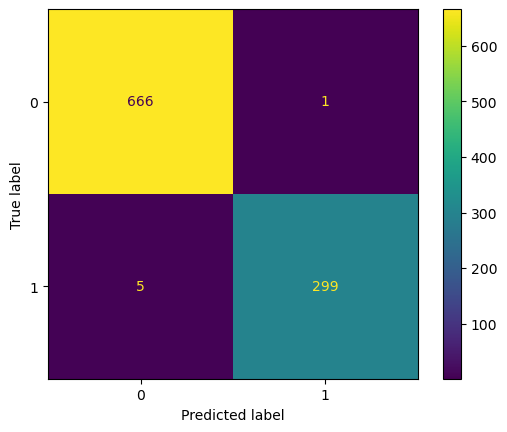

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Accuracy + report
print("Accuracy of Random Forest:", accuracy_score(y_test, y_pred) * 100, "%")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Conclusion:
If we consider the ones which are highly correlated to the output label,
features = {ejection_fraction, serum_creatinine, time}


* Logistic Regression --> 84%
* Random Forest --> 99%

### Model Building with SMOTE using logistical regression and random forest classifiers

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X = data.drop(columns=["DEATH_EVENT"])
y = data["DEATH_EVENT"]

# 1) split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# 2) SMOTE only on training set
smote = SMOTE(sampling_strategy="minority", random_state=0)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 3) scale 
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)

Accuracy of Logistic Regression: 82.08032955715757 %
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       674
           1       0.68      0.77      0.72       297

    accuracy                           0.82       971
   macro avg       0.79      0.81      0.80       971
weighted avg       0.83      0.82      0.82       971



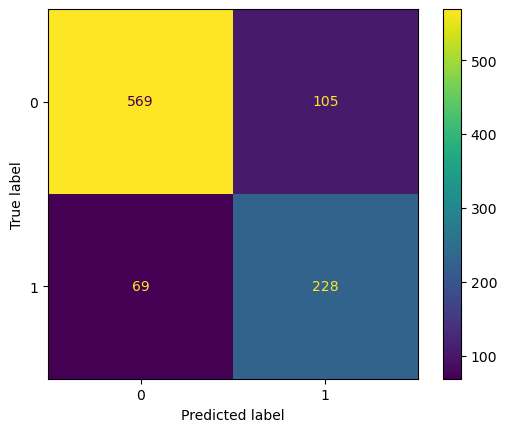

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train_sm, y_train_sm)

y_pred = lr_model.predict(X_test)

print("Accuracy of Logistic Regression:", accuracy_score(y_test, y_pred) * 100, "%")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

Accuracy of Random Forest: 99.1761071060762 %
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       674
           1       1.00      0.98      0.99       297

    accuracy                           0.99       971
   macro avg       0.99      0.99      0.99       971
weighted avg       0.99      0.99      0.99       971



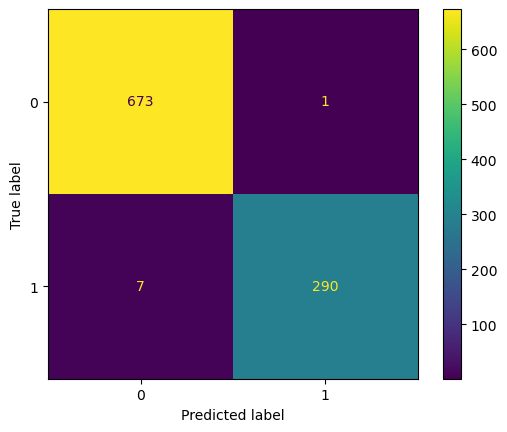

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train_sm, y_train_sm)   # train on SMOTE training set

y_pred = rf_model.predict(X_test)      # test stays ORIGINAL (no SMOTE)

print("Accuracy of Random Forest:", accuracy_score(y_test, y_pred) * 100, "%")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [138]:
# Results Table

import pandas as pd

results_table = pd.DataFrame({
    "Category": [
        "Strong Predictors",
        "Strong Predictors",
        "Strong Predictors",
        "Strong Predictors",
        "Moderate Predictors",
        "Moderate Predictors",
        "Weak / Removed Predictors",
        "Weak / Removed Predictors",
        "Weak / Removed Predictors"
    ],
    "Feature": [
        "time",
        "serum_creatinine",
        "ejection_fraction",
        "serum_sodium",
        "age",
        "high_blood_pressure",
        "platelets",
        "sex",
        "smoking"
    ],
    "Key Insight": [
        "Most influential survival indicator",
        "Strong kidney function marker linked to mortality",
        "Direct measure of cardiac performance",
        "Electrolyte imbalance impact on outcomes",
        "Risk increases with age",
        "Associated comorbidity risk",
        "Minimal contribution after feature selection",
        "Weak independent predictive power",
        "Weak independent predictive power"
    ]
})

results_table

,Category,Feature,Key Insight
0,Strong Predictors,time,Most influential survival indicator
1,Strong Predictors,serum_creatinine,Strong kidney function marker linked to mortality
2,Strong Predictors,ejection_fraction,Direct measure of cardiac performance
3,Strong Predictors,serum_sodium,Electrolyte imbalance impact on outcomes
4,Moderate Predictors,age,Risk increases with age
5,Moderate Predictors,high_blood_pressure,Associated comorbidity risk
6,Weak / Removed Predictors,platelets,Minimal contribution after feature selection
7,Weak / Removed Predictors,sex,Weak independent predictive power
8,Weak / Removed Predictors,smoking,Weak independent predictive power


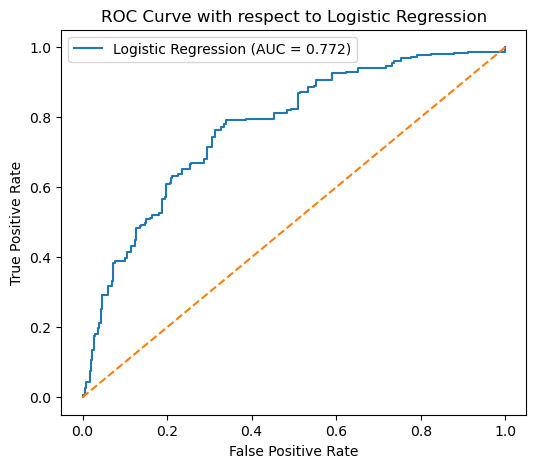

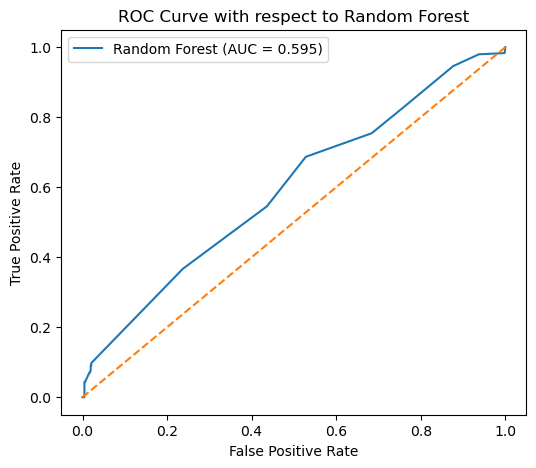

In [141]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Train models (don’t reuse "model")
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)

# ROC - Logistic Regression
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve with respect to Logistic Regression")
plt.legend(); plt.show()

# ROC - Random Forest
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve with respect to Random Forest")
plt.legend(); plt.show()

In [143]:
roc_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "ROC AUC": [0.772, 0.595],
    "Model Strength": [
        "Strong linear risk separation",
        "Limited probability ranking performance"
    ],
    "Key Insight": [
        "Generalizes well on clinical features",
        "Struggles with small feature set and SMOTE noise"
    ]
})

roc_results

,Model,ROC AUC,Model Strength,Key Insight
0,Logistic Regression,0.772,Strong linear risk separation,Generalizes well on clinical features
1,Random Forest,0.595,Limited probability ranking performance,Struggles with small feature set and SMOTE noise


In [142]:
### Conclusion:
# ROC–AUC analysis showed Logistic Regression achieved stronger discriminative performance (AUC ≈ 0.77) compared to Random Forest (AUC ≈ 0.60).
# Suggests largely linear relationships between clinical predictors and mortality risk. 
# This indicates simpler models may generalize better for this dataset, particularly under class balancing with SMOTE.
